In [107]:
# test_cartpole.py
import cartpole
import random
import time


def run_cartpole_c(max_total_steps: int = 10_000):
    env = cartpole.CartPoleEnv()
    state = env.reset()
    # print("Initial State:", state)

    done = False
    time_steps = 0
    total_steps = 0
    max_time_steps = 500

    start_time = time.time()

    while total_steps < max_total_steps:

        while not done and time_steps < max_time_steps:
            # Agent selects a random action
            action = random.randint(0, 1)
            state, reward, done = env.step(action)
            # print(f"Time Step: {time_steps}, Action: {action}, State: {state}, Reward: {reward}, Done: {done}")
            time_steps += 1
            total_steps += 1

            if total_steps >= max_total_steps:
                break

        if done:
            time_steps = 0
            done = False
            # print(f"Episode terminated after {time_steps} time steps.")
        # else:
            # print(f"Episode reached max time steps ({max_time_steps}).")
        env.reset()

    sps = total_steps / (time.time() - start_time)
    print(f"CartPole C:\nTotal Steps: {total_steps}, Steps per Second: {sps:.2f}")
    return sps

In [108]:
run_cartpole_c(10_000)

CartPole C:
Total Steps: 10000, Steps per Second: 1188356.42


1188356.4244227228

In [109]:
import gymnasium as gym

def run_cartpole_py(max_total_steps: int = 10_000):
    env = gym.make("CartPole-v1")
    state, info = env.reset()
    # print("Initial State:", state)

    done = False
    time_steps = 0
    total_steps = 0
    max_time_steps = 500

    start_time = time.time()

    while total_steps < max_total_steps:

        while not done and time_steps < max_time_steps:
            # Agent selects a random action
            action = env.action_space.sample()
            _, _, done, truncated, _ = env.step(action)
            time_steps += 1
            total_steps += 1

            if total_steps >= max_total_steps:
                break

        if done or truncated:
            time_steps = 0
            done = False

        env.reset()

    sps = total_steps / (time.time() - start_time)
    print(f"CartPole Python:\nTotal Steps: {total_steps}, Steps per Second: {sps:.2f}")
    return sps


In [110]:
run_cartpole_py(10_000)

CartPole Python:
Total Steps: 10000, Steps per Second: 141264.69


141264.68874511216

In [111]:
import time
import jax
jax.config.update("jax_enable_x64", True)
import gymnax

def run_cartpole_jax(max_total_steps: int = 10_000):
    key = jax.random.PRNGKey(0)
    env, env_params = gymnax.make("CartPole-v1")

    # JIT the environment functions
    jit_step = jax.jit(env.step)
    jit_reset = jax.jit(env.reset)

    total_steps = 0
    max_time_steps = 1000

    start_time = time.time()

    while total_steps < max_total_steps:
        # Reset the environment and keys at the start of each episode
        key, subkey = jax.random.split(key)
        obs, state = jit_reset(subkey, env_params)
        done = False
        time_steps = 0

        while not done and time_steps < max_time_steps:
            # Split keys for action and step
            key, subkey = jax.random.split(key)
            action = env.action_space(env_params).sample(subkey)

            key, subkey = jax.random.split(key)
            obs, state, reward, done, _ = jit_step(subkey, state, action, env_params)

            time_steps += 1
            total_steps += 1

            if total_steps >= max_total_steps:
                break

    sps = total_steps / (time.time() - start_time)
    print(f"CartPole JAX:\nTotal Steps: {total_steps}, Steps per Second: {sps:.2f}")
    return sps


In [112]:
run_cartpole_jax(10_000)

CartPole JAX:
Total Steps: 10000, Steps per Second: 6839.91


6839.90674004873

In [113]:
c_sps = run_cartpole_c(10_000)
py_sps = run_cartpole_py(10_000)
jax_sps = run_cartpole_jax(10_000)

print(f"Speedup: {c_sps / jax_sps:.2f}")
print(f"Speedup: {py_sps / jax_sps:.2f}")


CartPole C:
Total Steps: 10000, Steps per Second: 2152470.49
CartPole Python:
Total Steps: 10000, Steps per Second: 186046.38
CartPole JAX:
Total Steps: 10000, Steps per Second: 6219.08
Speedup: 346.11
Speedup: 29.92


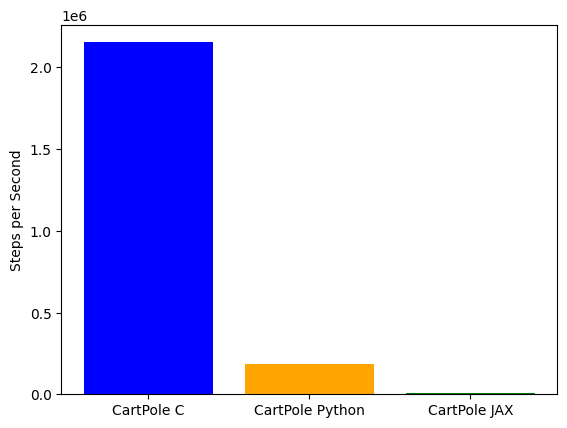

In [115]:
# Plot a histogram of the results
import matplotlib.pyplot as plt


plt.bar(["CartPole C", "CartPole Python", "CartPole JAX"], [c_sps, py_sps, jax_sps], color=["blue", "orange", "green"])
plt.ylabel("Steps per Second")
plt.show()